In [210]:
import pandas as pd
df=pd.read_csv('data/classification_train.csv')
problem = 'classification'

In [211]:
df

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


In [212]:
df.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [213]:
df

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


FILLING NULL VALUES

In [214]:
import numpy as np
import pandas as pd
from scipy.stats import shapiro,ks_2samp,norm
from scipy.spatial.distance import cdist
import math

class Preprocessor:

    # Attributes: df (Original DataFrame),  descriptor (Dataframe containing information about Null Values and Feature data type)
    # Methods : Called from outside: __inti__(df), fillNull()
    
    def __init__(self):
        self.descriptor=None
        self.drop_threshold = 30
        self.knn_threshold = 5
        self.ordinal_ratio = 0.05

        return
    
    def generateDescriptor(self,df):    # Generates descriptor df
        descriptor_df = pd.DataFrame(df.isnull().sum())
        descriptor_df[1] = round(descriptor_df[0]/df.shape[0],2)*100
        isNumerical=[]
        for column in df.columns:
            if df[column].dtype == 'int64' or df[column].dtype == 'float64':
                isNumerical.append(1)
            else:
                isNumerical.append(0)
        descriptor_df[2]=isNumerical
        return descriptor_df

    def checkDistribution(self,series):    # Labels feature distribution as Normal or Skewed
        if abs(series.skew())<0.5:
            return "normal"
        else:
            if series.shape[0]<5000:
                stat,p = shapiro(series)
            else:
                mu,sigma=series.mean(),series.std()
                stat,p = ks_2samp(series,norm.rvs(loc=mu,scale=sigma,size=len(series)))
            if p>0.05:
                return "normal"
            else:
                return "skewed"    

    def is_id_column(self,feature_series):    # Checks if feature is ID type
        value_range = feature_series.max() - feature_series.min()
        unique_count = feature_series.nunique()
        if unique_count == len(feature_series):
            if abs(value_range - unique_count) < 2:
                return True
        return False

    def knnImpute(self,df,descriptor_df,feature):    # KNN imputation based on categorical or numerical feature
        neighbour_features = [
            it for it in descriptor_df.index
            if descriptor_df[0][it] == 0
            and descriptor_df[2][it] == 1
            and not self.is_id_column(df[it])
            ]
    
        neighbour_df=df[neighbour_features]
        non_null=neighbour_df[df[feature].notna()]
        null=neighbour_df[df[feature].isna()]
        norm_min=neighbour_df.min()
        norm_range=neighbour_df.max()-neighbour_df.min()
        norm_range.replace(0,1e-9,inplace=True)
        non_null=(non_null-norm_min)/norm_range
        null=(null-norm_min)/norm_range
        distances = pd.DataFrame(cdist(null,non_null,metric='euclidean'))
        k=math.ceil(math.sqrt(non_null.shape[0]))
        k_nearest_indices= pd.DataFrame(np.argsort(distances,axis=1)).iloc[:,:k]
        
        for enumerated_null_index,df_index in enumerate(null.index):
            enumerated_non_null_indices=k_nearest_indices.loc[enumerated_null_index]
            true_df_indices=non_null.iloc[enumerated_non_null_indices].index
            neighbour_values = df[feature].loc[true_df_indices]
            if descriptor_df[2][feature]==1 and df[feature].nunique()/len(df[feature])>0.05:
                df.loc[df_index, feature] = neighbour_values.mean()
            else:
                df.loc[df_index, feature] = neighbour_values.mode().iloc[0]
    def replaceByNull(self,df,null_character):
        for feature in df.columns:
            if df[feature].dtype=='object':
                df[feature].replace(null_character,np.nan,inplace=True)
            else:
                df[feature].replace(int(null_character),np.nan,inplace=True)
        return df
        
    def fill_null(self,df,null_character=None):
        if  null_character is not None:
            df=self.replaceByNull(df,null_character)
        self.descriptor= self.generateDescriptor(df)
        for feature in self.descriptor.index:
            
            if self.descriptor[1][feature]>self.drop_threshold:    # Feature has more than 30% null values
                df.drop(feature,axis=1,inplace=True)    # Remove feature
                self.descriptor = self.generateDescriptor(df)    # Remake descriptor df
                continue
                
            if self.descriptor[2][feature]==1:    # Numerical feature
                
                if self.descriptor[1][feature]>self.knn_threshold:    # Null values between 5-30%
                    self.knnImpute(df,self.descriptor,feature)    # Use KNN
                    
                else:    # Null values between less than 5%
                    if df[feature].nunique()/len(df[feature])<self.ordinal_ratio:    # Ordinal Feature (Discrete Finite numerical)
                        df.loc[:, feature] = df[feature].fillna(df[feature].mode().iloc[0])  # Fill with mode
                        
                    elif self.checkDistribution(df[feature]) == 'normal':    # Normal numerical fetaure
                        df.loc[:, feature] = df[feature].fillna(df[feature].mean())    # Fill with mean
                        
                    else:    # Skewed numerical feature
                        df.loc[:, feature] = df[feature].fillna(df[feature].median())    # Fill with median
                        
            else:    # Categorical feature
                if self.descriptor[1][feature]>self.knn_threshold:    # Null values between 5-30%
                    self.knnImpute(df,self.descriptor,feature)    # Use KNN
                    
                else:    # Null values between less than 5%
                    df.loc[:, feature] = df[feature].fillna(df[feature].mode().iloc[0])   # Fill with mode

                    
        self.descriptor=self.generateDescriptor(df)    # Remake descriptor df
        return df


In [215]:
preprocessor=Preprocessor()
df1=preprocessor.fill_null(df)
df1.isnull().sum()


PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Embarked       0
dtype: int64

TRAIN VAL SPLIT

In [216]:
class Split:
    def __init__(self, df):
        self.df = df.copy()

    def X_y_split(self, target_feature):
        if target_feature in self.df.columns:
            y = self.df[target_feature]
            X = self.df.drop(columns=[target_feature])
            return X, y
        else:
            print(f"'{target_feature}' is not a feature of the given dataset.")
            return None, None

    def train_val_split(self, X, y, val_size=0.2, random_state=42):
        np.random.seed(random_state)
        indices = np.random.permutation(len(X))

        val_count = int(len(X) * val_size)
        val_idx, train_idx = indices[:val_count], indices[val_count:]

        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

        return X_train, X_val, y_train, y_val


In [217]:
sp=Split(df1)
X_train,y_train=sp.X_y_split('Survived')

In [218]:
X_train

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
0,1,3,"Braund, Mr. Owen Harris",male,22.000000,1,0,A/5 21171,7.2500,S
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.000000,1,0,PC 17599,71.2833,C
2,3,3,"Heikkinen, Miss. Laina",female,26.000000,0,0,STON/O2. 3101282,7.9250,S
3,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.000000,1,0,113803,53.1000,S
4,5,3,"Allen, Mr. William Henry",male,35.000000,0,0,373450,8.0500,S
...,...,...,...,...,...,...,...,...,...,...
886,887,2,"Montvila, Rev. Juozas",male,27.000000,0,0,211536,13.0000,S
887,888,1,"Graham, Miss. Margaret Edith",female,19.000000,0,0,112053,30.0000,S
888,889,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,26.574074,1,2,W./C. 6607,23.4500,S
889,890,1,"Behr, Mr. Karl Howell",male,26.000000,0,0,111369,30.0000,C


In [219]:
y_train

0      0
1      1
2      1
3      1
4      0
      ..
886    0
887    1
888    0
889    1
890    0
Name: Survived, Length: 891, dtype: int64

In [220]:
X_train,X_val,y_train,y_val=sp.train_val_split(X_train,y_train)

In [221]:
print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)

(713, 10)
(713,)
(178, 10)
(178,)


In [222]:
X_val

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
709,710,3,"Moubarek, Master. Halim Gonios (""William George"")",male,13.552593,1,1,2661,15.2458,C
439,440,2,"Kvillner, Mr. Johan Henrik Johannesson",male,31.000000,0,0,C.A. 18723,10.5000,S
840,841,3,"Alhomaki, Mr. Ilmari Rudolf",male,20.000000,0,0,SOTON/O2 3101287,7.9250,S
720,721,2,"Harper, Miss. Annie Jessie ""Nina""",female,6.000000,0,1,248727,33.0000,S
39,40,3,"Nicola-Yarred, Miss. Jamila",female,14.000000,1,0,2651,11.2417,C
...,...,...,...,...,...,...,...,...,...,...
852,853,3,"Boulos, Miss. Nourelain",female,9.000000,1,1,2678,15.2458,C
433,434,3,"Kallio, Mr. Nikolai Erland",male,17.000000,0,0,STON/O 2. 3101274,7.1250,S
773,774,3,"Elias, Mr. Dibo",male,30.518519,0,0,2674,7.2250,C
25,26,3,"Asplund, Mrs. Carl Oscar (Selma Augusta Emilia...",female,38.000000,1,5,347077,31.3875,S


In [223]:
y_val

709    1
439    0
840    0
720    1
39     1
      ..
852    0
433    0
773    0
25     1
84     1
Name: Survived, Length: 178, dtype: int64

In [224]:
y_train.dtype

dtype('int64')

ENCODING

In [225]:

import pandas as pd
import numpy as np
from sklearn.model_selection import KFold
from category_encoders.target_encoder import TargetEncoder

class InputEncoder:
    def __init__(self, n_splits=5, random_state=42):
        self.n_splits = n_splits
        self.random_state = random_state
        self.target_features = None
        self.global_encoder = None  # Used to transform test/val data
        self.fitted = False

    def fit(self, X, y):
        X = X.copy()
        y = y.copy()
        self.target_features = X.select_dtypes(include=['object', 'category']).columns.tolist()

        oof_encoded = pd.DataFrame(index=X.index, columns=self.target_features)

        kf = KFold(n_splits=self.n_splits, shuffle=True, random_state=self.random_state)

        for train_idx, val_idx in kf.split(X):
            X_train_fold, y_train_fold = X.iloc[train_idx], y.iloc[train_idx]
            X_val_fold = X.iloc[val_idx]

            fold_encoder = TargetEncoder()
            fold_encoder.fit(X_train_fold[self.target_features], y_train_fold)

            oof_encoded.iloc[val_idx] = fold_encoder.transform(X_val_fold[self.target_features]).values

        # Save final encoder trained on full data (for test/val transform)
        self.global_encoder = TargetEncoder()
        self.global_encoder.fit(X[self.target_features], y)

        self.oof_encoded = oof_encoded.astype(float)
        self.fitted = True
        return self

    def transform(self, X):
        if not self.fitted:
            raise ValueError("CVTargetEncoder must be fitted before calling transform()")

        X = X.copy()

        if set(self.target_features).issubset(X.columns):
            X_encoded = self.global_encoder.transform(X[self.target_features])
            X[self.target_features] = X_encoded
        else:
            raise ValueError("Input data missing some categorical features seen during fit.")

        return X



In [226]:
input_encoder=InputEncoder()
input_encoder.fit(X_train,y_train)

In [227]:
X_train_te = input_encoder.transform(X_train)
X_val_te = input_encoder.transform(X_val)

In [228]:
from sklearn.preprocessing import LabelEncoder

class OutputEncoder:
    def __init__(self):
        self.encoder = LabelEncoder()
        self.encoding_map = {}

    def fit_transform(self, y):
        if y.dtype != 'object':
            return y
        y_encoded = self.encoder.fit_transform(y)
        self.encoding_map = {index: label for index, label in enumerate(self.encoder.classes_)}
        return y_encoded

    def transform(self, y):
        if y.dtype != 'object':
            return y
        return self.encoder.transform(y)

    def inverse_transform(self, y):
        return self.encoder.inverse_transform(y)

    def get_encoding_map(self):
        return self.encoding_map


In [229]:
output_encoder = OutputEncoder()
y_train_te = output_encoder.fit_transform(y_train)
y_val_te = output_encoder.transform(y_val)


In [230]:
print(X_train_te.shape)
print(y_train_te.shape)
print(X_val_te.shape)
print(y_val_te.shape)

(713, 10)
(713,)
(178, 10)
(178,)


In [231]:
X_train_te

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
10,11,3,0.458300,0.739837,4.000000,1,1,0.465613,16.7000,0.339015
331,332,1,0.328192,0.186296,45.500000,0,0,0.328192,28.5000,0.339015
733,734,2,0.328192,0.186296,23.000000,0,0,0.328192,13.0000,0.339015
382,383,3,0.328192,0.186296,32.000000,0,0,0.328192,7.9250,0.339015
704,705,3,0.328192,0.186296,26.000000,1,0,0.328192,7.8542,0.339015
...,...,...,...,...,...,...,...,...,...,...
106,107,3,0.458300,0.739837,21.000000,0,0,0.458300,7.6500,0.339015
270,271,1,0.328192,0.186296,50.981481,0,0,0.328192,31.0000,0.339015
860,861,3,0.328192,0.186296,41.000000,2,0,0.328192,14.1083,0.339015
435,436,1,0.458300,0.739837,14.000000,1,2,0.473468,120.0000,0.339015


In [232]:
y_train_te.index

Index([ 10, 331, 733, 382, 704, 813, 118, 536, 361,  29,
       ...
       121, 614,  20, 700,  71, 106, 270, 860, 435, 102],
      dtype='int64', length=713)

OUTLIER HANDLING

In [233]:
import pandas as pd
import numpy as np
from scipy.stats import zscore
from sklearn.ensemble import IsolationForest


class OutlierHandler:
    def __init__(self, X_train_encoded, X_val_encoded, y_train, y_val, problem_type, aggression=20.0):
        self.X_train = X_train_encoded.copy()
        self.X_val = X_val_encoded.copy()
        self.y_train = y_train.copy()
        self.y_val = y_val.copy() if y_val is not None else None

        self.X = pd.concat([self.X_train, self.X_val])
        self.preprocessor = Preprocessor()

        if not (0 < aggression <= 100):
            raise ValueError("Invalid aggression value! Must be between 1 and 100.")
        self.sensitivity = aggression

        if problem_type not in ["classification", "regression"]:
            raise ValueError("Invalid problem type. Must be 'classification' or 'regression'.")
        self.problem_type = problem_type
        self.vote_threshold = 2 if problem_type == "classification" else 1

        self.outliers = {}
        self.outlier_indexes = {"X_train": {}, "X_val": {}}

        print(f"[INIT] Aggression set to: {self.sensitivity}")
        print(f"[INIT] Problem type: {self.problem_type} | Vote threshold: {self.vote_threshold}")
        print(f"[INIT] Combined data shape: {self.X.shape}")

    def detect_outliers(self):
        print("\n[DETECTION] Starting outlier detection...")
        for feature in self.X.columns:
            distribution = self.preprocessor.checkDistribution(self.X[feature])
            print(f"\n🔍 Checking feature: '{feature}' | Distribution: {distribution}")

            z_outliers, iqr_outliers, iso_outliers = set(), set(), set()

            # Sensitivity Tuning
            z_threshold = 3 / (1 + np.log1p(self.sensitivity))
            iqr_multiplier = 1.5 * (1 + (self.sensitivity ** 0.3))
            contamination_rate = min(0.05 + (self.sensitivity / 200), 0.25)

            # Z-score method
            if distribution == "normal" and self.X[feature].std() > 1e-8:
                z_scores = np.abs(zscore(self.X[feature]))
                z_outliers = set(self.X.index[z_scores > z_threshold])
                print(f"  📏 Z-score outliers: {len(z_outliers)}")
                print(f"    🔹 Indexes: {sorted(z_outliers)}")
            else:
                print("  🚫 Skipping Z-score (non-normal distribution)")

            # IQR method
            Q1, Q3 = np.percentile(self.X[feature], [25, 75])
            IQR = Q3 - Q1
            lower_bound = Q1 - iqr_multiplier * IQR
            upper_bound = Q3 + iqr_multiplier * IQR
            iqr_outliers = set(self.X.index[(self.X[feature] < lower_bound) | (self.X[feature] > upper_bound)])
            print(f"  📦 IQR outliers: {len(iqr_outliers)}")
            print(f"    🔹 Indexes: {sorted(iqr_outliers)}")

            # Isolation Forest
            if len(iqr_outliers | z_outliers) > 0.1 * len(self.X):
                clf = IsolationForest(contamination=contamination_rate, random_state=42)
                preds = clf.fit_predict(self.X[[feature]])
                iso_outliers = set(self.X.index[preds == -1])
                print(f"  🌲 Isolation Forest outliers: {len(iso_outliers)}")
                print(f"    🔹 Indexes: {sorted(iso_outliers)}")
            else:
                print("  🚫 Skipping Isolation Forest (not enough IQR/Z-score outliers)")

            # Voting Logic
            all_outliers = z_outliers | iqr_outliers | iso_outliers
            print(f"  ✅ Total unique outliers for '{feature}': {len(all_outliers)}")
            print(f"    🔹 All Indexes: {sorted(all_outliers)}")

            self.outliers[feature] = all_outliers

            for idx in all_outliers:
                votes = (idx in z_outliers) + (idx in iqr_outliers) + (idx in iso_outliers)
                if votes >= self.vote_threshold:
                    if idx in self.X_train.index:
                        self.outlier_indexes["X_train"].setdefault(idx, []).append(feature)
                    elif idx in self.X_val.index:
                        self.outlier_indexes["X_val"].setdefault(idx, []).append(feature)

        print(f"\n[DETECTION COMPLETE] Outliers detected for {len(self.outliers)} features.")
        return self.outlier_indexes

    def handle_outliers(self, remove_indices=[], keep_indices=[]):
        print("\n[HANDLING] Handling outliers...")
    
        datasets = [("X_train", self.X_train, self.y_train)]
        if self.X_val is not None:
            datasets.append(("X_val", self.X_val, self.y_val if self.y_val is not None else None))
    
        for dataset_name, X, y in datasets:
            print(f"\n[DATASET] Handling: {dataset_name}")
            outlier_map = self.outlier_indexes.get(dataset_name, {})
    
            # Convert y to Series for consistent indexing
            if y is not None:
                y = pd.Series(y, index=X.index)
    
            to_remove = [idx for idx in remove_indices if idx in X.index]
            print(f"[REMOVE] Indices to remove from {dataset_name}: {len(to_remove)}")
            print(f"    🔹 {sorted(to_remove)}")
    
            if len(to_remove) > 0:
                print(f"[DROP] Dropping from X before: {X.shape}")
                X = X.drop(index=to_remove)
                print(f"[DROP] Dropping from X after:  {X.shape}")
    
                if y is not None:
                    print(f"[DROP] Dropping from y before: {y.shape}")
                    y = y.drop(index=to_remove)
                    print(f"[DROP] Dropping from y after:  {y.shape}")
    
            # Cap outliers
            transformed = 0
            for idx, features in outlier_map.items():
                if idx in keep_indices or idx not in X.index:
                    continue
    
                for feature in features:
                    Q1, Q3 = np.percentile(X[feature], [25, 75])
                    IQR = Q3 - Q1
                    lower_bound = Q1 - 1.5 * IQR
                    upper_bound = Q3 + 1.5 * IQR
    
                    old_value = X.at[idx, feature]
                    if old_value < lower_bound:
                        X.at[idx, feature] = Q1
                        print(f"    ✂️ Lower Outlier at idx={idx}, feature='{feature}': {old_value:.4f} → {Q1:.4f}")
                        transformed += 1
                    elif old_value > upper_bound:
                        X.at[idx, feature] = Q3
                        print(f"    ✂️ Upper Outlier at idx={idx}, feature='{feature}': {old_value:.4f} → {Q3:.4f}")
                        transformed += 1
    
            print(f"[TRANSFORM] Transformed {transformed} values in {dataset_name}")
    
            if dataset_name == "X_train":
                self.X_train = X
                self.y_train = y.values.ravel() if y is not None else None
                assert len(self.X_train) == len(self.y_train), f"❌ Length mismatch: X_train({len(self.X_train)}) vs y_train({len(self.y_train)})"
            elif dataset_name == "X_val":
                self.X_val = X
                self.y_val = y.values.ravel() if y is not None else None
                if self.y_val is not None:
                    assert len(self.X_val) == len(self.y_val), f"❌ Length mismatch: X_val({len(self.X_val)}) vs y_val({len(self.y_val)})"
    
        print(f"\n[HANDLING COMPLETE] Final shapes => X_train: {self.X_train.shape}, X_val: {self.X_val.shape}")
        return self.X_train, self.X_val, self.y_train, self.y_val


In [234]:
oh = OutlierHandler(X_train_te,X_val_te,y_train_te,y_val_te,problem,1)

[INIT] Aggression set to: 1
[INIT] Problem type: classification | Vote threshold: 2
[INIT] Combined data shape: (891, 10)


In [235]:
outliers_dict=oh.detect_outliers()


[DETECTION] Starting outlier detection...

🔍 Checking feature: 'PassengerId' | Distribution: normal
  📏 Z-score outliers: 0
    🔹 Indexes: []
  📦 IQR outliers: 0
    🔹 Indexes: []
  🚫 Skipping Isolation Forest (not enough IQR/Z-score outliers)
  ✅ Total unique outliers for 'PassengerId': 0
    🔹 All Indexes: []

🔍 Checking feature: 'Pclass' | Distribution: skewed
  🚫 Skipping Z-score (non-normal distribution)
  📦 IQR outliers: 0
    🔹 Indexes: []
  🚫 Skipping Isolation Forest (not enough IQR/Z-score outliers)
  ✅ Total unique outliers for 'Pclass': 0
    🔹 All Indexes: []

🔍 Checking feature: 'Name' | Distribution: skewed
  🚫 Skipping Z-score (non-normal distribution)
  📦 IQR outliers: 0
    🔹 Indexes: []
  🚫 Skipping Isolation Forest (not enough IQR/Z-score outliers)
  ✅ Total unique outliers for 'Name': 0
    🔹 All Indexes: []

🔍 Checking feature: 'Sex' | Distribution: skewed
  🚫 Skipping Z-score (non-normal distribution)
  📦 IQR outliers: 0
    🔹 Indexes: []
  🚫 Skipping Isolation 

In [236]:
outliers_dict

{'X_train': {261: ['Age'],
  788: ['Age'],
  803: ['Age'],
  43: ['Age'],
  555: ['Age'],
  305: ['Age'],
  570: ['Age'],
  58: ['Age'],
  827: ['Age'],
  829: ['Age'],
  831: ['Age'],
  326: ['Age'],
  851: ['Age'],
  348: ['Age'],
  116: ['Age'],
  630: ['Age'],
  374: ['Age'],
  381: ['Age'],
  386: ['Age'],
  644: ['Age'],
  407: ['Age'],
  672: ['Age'],
  164: ['Age'],
  170: ['Age'],
  172: ['Age'],
  183: ['Age'],
  438: ['Age', 'Parch'],
  193: ['Age'],
  456: ['Age'],
  469: ['Age'],
  483: ['Age'],
  745: ['Age'],
  233: ['Age'],
  755: ['Age'],
  252: ['Age'],
  13: ['Parch'],
  567: ['Parch'],
  610: ['Parch'],
  638: ['Parch'],
  678: ['Parch'],
  167: ['Parch'],
  774: ['Parch'],
  858: ['Parch'],
  437: ['Parch']},
 'X_val': {777: ['Age'],
  275: ['Age'],
  280: ['Age'],
  545: ['Age'],
  33: ['Age'],
  54: ['Age'],
  78: ['Age'],
  96: ['Age'],
  625: ['Age'],
  448: ['Age'],
  493: ['Age'],
  25: ['Parch'],
  86: ['Parch'],
  736: ['Parch'],
  360: ['Parch'],
  885: ['

In [237]:
drop_rows = list(outliers_dict['X_train'].keys()) + list(outliers_dict['X_val'].keys())

In [238]:
len(drop_rows)

60

In [239]:
X_train.loc[outliers_dict['X_train'].keys(),:].shape

(44, 10)

In [240]:
X_train_handled,X_val_handled,y_train_handled,y_val_handled = oh.handle_outliers([],drop_rows)


[HANDLING] Handling outliers...

[DATASET] Handling: X_train
[REMOVE] Indices to remove from X_train: 0
    🔹 []
[TRANSFORM] Transformed 0 values in X_train

[DATASET] Handling: X_val
[REMOVE] Indices to remove from X_val: 0
    🔹 []
[TRANSFORM] Transformed 0 values in X_val

[HANDLING COMPLETE] Final shapes => X_train: (713, 10), X_val: (178, 10)


In [173]:
X_train_handled

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
0,1,3,0.333898,0.188908,22.000000,1,0,0.333898,7.2500,0.339009
1,2,1,0.464006,0.742038,38.000000,1,0,0.464006,71.2833,0.553571
2,3,3,0.464006,0.742038,26.000000,0,0,0.464006,7.9250,0.339009
3,4,1,0.464006,0.742038,35.000000,1,0,0.400316,53.1000,0.339009
4,5,3,0.333898,0.188908,35.000000,0,0,0.333898,8.0500,0.339009
...,...,...,...,...,...,...,...,...,...,...
886,887,2,0.333898,0.188908,27.000000,0,0,0.333898,13.0000,0.339009
887,888,1,0.464006,0.742038,19.000000,0,0,0.464006,30.0000,0.339009
888,889,3,0.333898,0.742038,26.574074,1,2,0.329391,23.4500,0.339009
889,890,1,0.464006,0.188908,26.000000,0,0,0.464006,30.0000,0.553571


In [174]:
y_train_handled

array([0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1,
       1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1,
       1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1,
       1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0,
       0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0,
       1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0,
       1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0,
       0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0,
       1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1,

In [175]:
print(X_train_handled.shape)
print(y_train_handled.shape)
print(X_val_handled.shape)
print(y_val_handled.shape)

(891, 10)
(891,)
(178, 10)
(178,)


SCALING

In [88]:
class StandardScalerCustom:
    def __init__(self):
        self.means = None
        self.stds = None
        self.columns_to_drop = []
    
    def fit(self, X):
        self.means = X.mean()
        self.stds = X.std(ddof=0)  # Use population std
    
    def transform(self, X):
        # Drop the same constant columns identified during fit
        X = X.drop(columns=self.columns_to_drop, errors='ignore')
        return (X - self.means) / self.stds

    def fit_transform(self, X):
        self.fit(X)
        return self.transform(X)

    def scale_features(self, X_train, X_val):
        # Detect constant columns in both train and val
        constant_train = set(X_train.columns[X_train.nunique() == 1])
        constant_val = set(X_val.columns[X_val.nunique() == 1])
        self.columns_to_drop = list(constant_train & constant_val)

        # Drop those columns
        X_train = X_train.drop(columns=self.columns_to_drop, errors='ignore')
        X_val = X_val.drop(columns=self.columns_to_drop, errors='ignore')

        # Fit on train and transform both
        X_train_scaled = self.fit_transform(X_train)
        X_val_scaled = self.transform(X_val)
        return X_train_scaled, X_val_scaled


In [89]:
scaler=StandardScalerCustom()
X_train_scaled,X_val_scaled = scaler.scale_features(X_train_handled,X_val_handled)

In [90]:
X_train_scaled

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
10,-1.699625,0.812087,1.284740,1.377815,-1.858908,0.379618,0.783811,1.426236,-0.305665,-0.495582
331,-0.450076,-1.615661,-0.778367,-0.725787,1.176623,-0.471538,-0.480572,-0.798933,-0.078304,-0.495582
733,1.114779,-0.401787,-0.778367,-0.725787,-0.469147,-0.471538,-0.480572,-0.798933,-0.376956,-0.495582
382,-0.251550,0.812087,-0.778367,-0.725787,0.189161,-0.471538,-0.480572,-0.798933,-0.474740,-0.495582
704,1.001892,0.812087,-0.778367,-0.725787,-0.249711,0.379618,-0.480572,-0.798933,-0.476104,-0.495582
...,...,...,...,...,...,...,...,...,...,...
106,-1.325928,0.812087,1.284740,1.377815,-0.615438,-0.471538,-0.480572,1.307832,-0.480038,-0.495582
270,-0.687529,-1.615661,-0.778367,-0.725787,1.577567,-0.471538,-0.480572,-0.798933,-0.030135,-0.495582
860,1.609149,0.812087,-0.778367,-0.725787,0.847469,1.230775,-0.480572,-0.798933,-0.355601,-0.495582
435,-0.045238,-1.615661,1.284740,1.377815,-1.127455,0.379618,2.048194,1.553430,1.684702,-0.495582


FEATURE SELECTION

In [91]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.feature_selection import mutual_info_classif, mutual_info_regression

class FeatureSelection:
    def __init__(self, X_train, X_val, y_train, problem, corr_threshold=0.95, importance_threshold=0.01):
        self.X_train = X_train.copy()
        self.X_val = X_val.copy()
        self.y_train = y_train
        self.problem = problem
        self.corr_threshold = corr_threshold
        self.importance_threshold = importance_threshold
        self.final_features = None

    def remove_low_variance_features(self):
        variances = self.X_train.var()
        low_var_cols = variances[variances < 1e-5].index
        self.X_train.drop(columns=low_var_cols, inplace=True)
        self.X_val.drop(columns=low_var_cols, inplace=True)
        print(f"Removed {len(low_var_cols)} low-variance features.")
        if self.X_train.shape[1] == 0:
            raise ValueError("All features have low variance. Nothing left to train on.")

    def remove_highly_correlated_features(self):
        corr_matrix = self.X_train.corr().abs()
        upper_triangle = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
        to_drop = [col for col in upper_triangle.columns if any(upper_triangle[col] > self.corr_threshold)]
        self.X_train.drop(columns=to_drop, inplace=True)
        self.X_val.drop(columns=to_drop, inplace=True)
        print(f"Removed {len(to_drop)} highly correlated features.")
        if self.X_train.shape[1] == 0:
            raise ValueError("All features dropped due to high correlation. Adjust `corr_threshold`.")

    def select_important_features(self):
        if self.problem == 'classification':
            model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
            mi_func = mutual_info_classif
        elif self.problem == 'regression':
            model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
            mi_func = mutual_info_regression
        else:
            raise ValueError("Invalid problem type. Choose 'classification' or 'regression'.")

        model.fit(self.X_train, self.y_train)
        feature_importances = pd.Series(model.feature_importances_, index=self.X_train.columns)
        selected_features = feature_importances[feature_importances > self.importance_threshold].index

        mi_scores = pd.Series(mi_func(self.X_train, self.y_train), index=self.X_train.columns)
        mi_selected_features = mi_scores[mi_scores > 0].index

        final_features = list(set(selected_features) & set(mi_selected_features))

        if len(final_features) == 0:
            print("Warning: No features passed both thresholds. Using top 10 by importance.")
            final_features = feature_importances.sort_values(ascending=False).head(10).index.tolist()

        self.final_features = final_features
        self.X_train = self.X_train[final_features]
        self.X_val = self.X_val[final_features]
        print(f"Selected {len(final_features)} important features.")
        print("Top 5 selected features:", final_features[:5])

    def transform(self):
        return self.X_train, self.X_val

    def fit_transform(self):
        self.remove_low_variance_features()
        self.remove_highly_correlated_features()
        self.select_important_features()
        return self.transform()

    def test_transform(self, X_test):
        return X_test[self.final_features]


In [92]:
feature_selector = FeatureSelection(X_train_scaled,X_val_scaled,y_train_handled,problem)

In [93]:
X_train_new,X_val_new = feature_selector.fit_transform()

Removed 0 low-variance features.
Removed 0 highly correlated features.
Selected 6 important features.
Top 5 selected features: ['Fare', 'Sex', 'Ticket', 'Name', 'Age']


In [94]:
X_train_new

,Fare,Sex,Ticket,Name,Age,Pclass
10,-0.305665,1.377815,1.426236,1.284740,-1.858908,0.812087
331,-0.078304,-0.725787,-0.798933,-0.778367,1.176623,-1.615661
733,-0.376956,-0.725787,-0.798933,-0.778367,-0.469147,-0.401787
382,-0.474740,-0.725787,-0.798933,-0.778367,0.189161,0.812087
704,-0.476104,-0.725787,-0.798933,-0.778367,-0.249711,0.812087
...,...,...,...,...,...,...
106,-0.480038,1.377815,1.307832,1.284740,-0.615438,0.812087
270,-0.030135,-0.725787,-0.798933,-0.778367,1.577567,-1.615661
860,-0.355601,-0.725787,-0.798933,-0.778367,0.847469,0.812087
435,1.684702,1.377815,1.553430,1.284740,-1.127455,-1.615661


In [95]:
X_val_new

,Fare,Sex,Ticket,Name,Age,Pclass
709,-0.333684,-0.725787,-0.004095,1.760462e-15,-1.160180,0.812087
439,-0.425125,-0.725787,-0.004095,1.760462e-15,0.116016,-0.401787
840,-0.474740,-0.725787,-0.004095,1.760462e-15,-0.688583,0.812087
720,0.008401,1.377815,0.277784,1.760462e-15,-1.712617,-0.401787
39,-0.410834,1.377815,1.307832,1.760462e-15,-1.127455,0.812087
...,...,...,...,...,...,...
852,-0.333684,1.377815,-0.798933,1.760462e-15,-1.493181,0.812087
433,-0.490154,-0.725787,-0.004095,1.760462e-15,-0.908019,0.812087
773,-0.488227,-0.725787,-0.004095,1.760462e-15,0.080798,0.812087
25,-0.022669,1.377815,0.719710,1.760462e-15,0.628033,0.812087


DIMENSIONALITY REDUCTION

In [96]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from typing import Optional


class DimensionalityReducer:
    def __init__(
        self,
        task_type: str = 'classification',
        variance_threshold: float = 0.95,
        force_method: Optional[str] = None
    ):
        if task_type not in ['classification', 'regression']:
            raise ValueError("task_type must be either 'classification' or 'regression'")
        if not (0 < variance_threshold <= 1):
            raise ValueError("variance_threshold must be between 0 and 1")
        if force_method not in [None, 'pca', 'lda']:
            raise ValueError("force_method must be either 'pca', 'lda', or None")

        self.task_type = task_type
        self.variance_threshold = variance_threshold
        self.force_method = force_method
        self.reducer_ = None
        self.reducer_method = None
        self.fitted = False
        self.feature_names_in_ = None
        self.n_features_in_ = None
        self.feature_importance_ = pd.DataFrame()

    def _validate_data(self, X):
        if not isinstance(X, pd.DataFrame):
            raise TypeError("X must be a pandas DataFrame")
        if X.isnull().any().any():
            raise ValueError("X contains missing values")
        if np.isinf(X.values).any():
            raise ValueError("X contains infinite values")
        if self.fitted and X.shape[1] != self.n_features_in_:
            raise ValueError(
                f"X has {X.shape[1]} features, but DimensionalityReducer was trained with {self.n_features_in_} features"
            )

    def _choose_method(self, X, y):
        if self.force_method:
            return self.force_method
        if self.task_type == 'classification' and y is not None:
            try:
                lda = LinearDiscriminantAnalysis()
                lda.fit(X, y)
                return 'lda'
            except Exception:
                import warnings
                warnings.warn("LDA failed due to singular matrices, falling back to PCA")
                return 'pca'
        return 'pca'

    def fit(self, X: pd.DataFrame, y: Optional[pd.Series] = None):
        self._validate_data(X)
        self.feature_names_in_ = X.columns.tolist()
        self.n_features_in_ = X.shape[1]

        method = self._choose_method(X, y)
        self.reducer_method = method

        if method == 'pca':
            pca = PCA(n_components=None)
            pca.fit(X)
            cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
            n_components = np.searchsorted(cumulative_variance, self.variance_threshold) + 1
            self.reducer_ = PCA(n_components=n_components)
            self.reducer_.fit(X)

            # PCA feature importance (custom)
            loading_vectors = np.abs(self.reducer_.components_)
            weighted = loading_vectors.T @ self.reducer_.explained_variance_ratio_[:n_components]
            self.feature_importance_ = pd.DataFrame({
                'Feature': self.feature_names_in_,
                '% Variance Explained': 100 * weighted / weighted.sum()
            }).sort_values('% Variance Explained', ascending=False)

        elif method == 'lda':
            lda = LinearDiscriminantAnalysis()
            lda.fit(X, y)
            self.reducer_ = lda

            # LDA feature importance (custom)
            coefs = np.abs(lda.coef_[0])
            importance = coefs / np.sum(coefs)
            self.feature_importance_ = pd.DataFrame({
                'Feature': self.feature_names_in_,
                'Discrimination Power': 100 * importance
            }).sort_values('Discrimination Power', ascending=False)

        else:
            raise ValueError(f"Invalid reduction method: {method}")

        self.fitted = True
        return self

    def transform(self, X: pd.DataFrame) -> pd.DataFrame:
        self._validate_data(X)
        if not self.fitted:
            raise RuntimeError("Call fit before transform")

        transformed = self.reducer_.transform(X)
        n_components = transformed.shape[1]
        return pd.DataFrame(
            transformed,
            columns=[f"Component_{i+1}" for i in range(n_components)],
            index=X.index
        )

    def fit_transform(self, X: pd.DataFrame, y: Optional[pd.Series] = None) -> pd.DataFrame:
        return self.fit(X, y).transform(X)

    def get_feature_importance(self) -> pd.DataFrame:
        if self.feature_importance_.empty:
            raise RuntimeError("Call fit first to compute feature importance")
        return self.feature_importance_.copy()


In [97]:
dr = DimensionalityReduction(X_train_new, X_val_new,y_train,problem)

Any NaNs in X_train_scaled? False
Any infinities in X_train_scaled? False


In [98]:
X_train_dr,X_val_dr = dr.apply()

In [99]:
dr.feature_importance

,Feature,Discrimination Power
0,Ticket,55.596628
1,Sex,26.857324
2,Fare,11.897264
3,Age,3.385896
4,Pclass,2.037911
5,Name,0.224977


In [100]:
X_train_dr

,0
10,1.866386
331,-1.042929
733,-1.050142
382,-1.143249
704,-1.119921
...,...
106,1.662150
270,-1.055380
860,-1.156130
435,2.393691


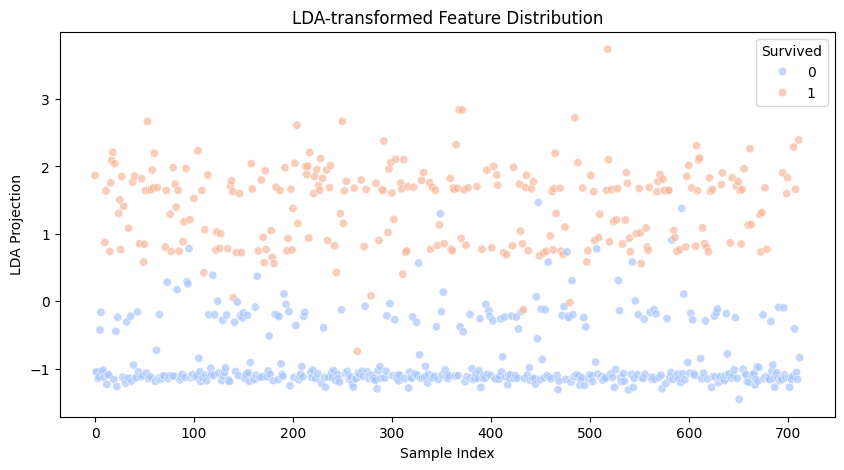

In [101]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 5))
sns.scatterplot(x=range(len(X_train_dr)), y=np.array(X_train_dr[0]).flatten(), hue=y_train, palette='coolwarm', alpha=0.7)
plt.xlabel("Sample Index")
plt.ylabel("LDA Projection")
plt.title("LDA-transformed Feature Distribution")
plt.legend(title="Survived")
plt.show()


In [102]:
output_encoder.get_encoding_map()

{}

In [176]:
import numpy as np
import pandas as pd
import copy
import optuna

from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.svm import SVC, SVR
from sklearn.metrics import f1_score, mean_squared_error

from xgboost import XGBClassifier, XGBRegressor
from lightgbm import LGBMClassifier, LGBMRegressor
from catboost import CatBoostClassifier, CatBoostRegressor


class ModelSelector:
    def __init__(self, problem_type, fixed_model=None, n_splits=5):
        problem_type = problem_type.lower()
        assert problem_type in ['classification', 'regression'], "Invalid problem type"
        self.problem_type = problem_type
        self.n_splits = n_splits
        self.fixed_model = fixed_model
        self.best_model = None
        self.best_params = None
        self.best_score = None
        self.best_trial = None

    def objective(self, trial, X, y):
        if isinstance(X, pd.DataFrame):
            X = X.reset_index(drop=True)
        if isinstance(y, pd.Series):
            y = y.reset_index(drop=True)

        # Dynamic search range based on data size
        n_samples = X.shape[0]
        small_data = n_samples < 1000
        self.estimators_range = (50, 150) if small_data else (50, 300)
        self.depth_range = (3, 8) if small_data else (3, 15)

        if self.problem_type == 'classification':
            model_type = self.fixed_model or trial.suggest_categorical("model", [
                "LogisticRegression", "RandomForest", "XGBoost", "LightGBM", "CatBoost", "SVM"])
            kf = StratifiedKFold(n_splits=self.n_splits, shuffle=True, random_state=42)
        else:
            model_type = self.fixed_model or trial.suggest_categorical("model", [
                "LinearRegression", "RandomForestRegressor", "XGBRegressor", "LightGBMRegressor", "CatBoostRegressor", "SVR"])
            kf = KFold(n_splits=self.n_splits, shuffle=True, random_state=42)

        scores = []
        models = []

        for train_idx, val_idx in kf.split(X, y):
            X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
            y_train, y_val = y[train_idx], y[val_idx]

            model = self.get_model(trial, model_type)
            model.fit(X_train, y_train)
            y_pred = model.predict(X_val)

            models.append(copy.deepcopy(model))

            if self.problem_type == 'classification':
                score = f1_score(y_val, y_pred, average='weighted')
            else:
                score = mean_squared_error(y_val, y_pred)

            scores.append(score)

        avg_score = np.mean(scores)

        # Track best model based on correct optimization direction
        is_better = (
            avg_score > self.best_score if self.problem_type == 'classification'
            else avg_score < self.best_score
        )
        if is_better:
            self.best_score = avg_score
            best_idx = np.argmax(scores) if self.problem_type == 'classification' else np.argmin(scores)
            self.best_model = models[best_idx]
            self.best_params = trial.params

        # Early stopping if model is excellent
        if self.problem_type == 'classification' and avg_score > 0.99:
            raise optuna.exceptions.TrialPruned()
        if self.problem_type == 'regression' and avg_score < 0.1:
            raise optuna.exceptions.TrialPruned()

        return avg_score

    def get_model(self, trial, model_type):
        est_range = self.estimators_range
        depth_range = self.depth_range

        if model_type == "LogisticRegression":
            return LogisticRegression(C=trial.suggest_float("lr_C", 0.01, 10, log=True))

        elif model_type == "RandomForest":
            return RandomForestClassifier(
                n_estimators=trial.suggest_int("rf_n_estimators", *est_range),
                max_depth=trial.suggest_int("rf_max_depth", *depth_range)
            )

        elif model_type == "XGBoost":
            return XGBClassifier(
                n_estimators=trial.suggest_int("xgb_n_estimators", *est_range),
                learning_rate=trial.suggest_float("xgb_learning_rate", 0.01, 0.3, log=True),
                use_label_encoder=False,
                eval_metric='logloss',
                verbosity=0
            )

        elif model_type == "LightGBM":
            return LGBMClassifier(
                n_estimators=trial.suggest_int("lgb_n_estimators", *est_range),
                learning_rate=trial.suggest_float("lgb_learning_rate", 0.01, 0.3, log=True),
                verbosity=-1
            )

        elif model_type == "CatBoost":
            return CatBoostClassifier(
                n_estimators=trial.suggest_int("cat_n_estimators", *est_range),
                depth=trial.suggest_int("cat_depth", *depth_range),
                verbose=0
            )

        elif model_type == "SVM":
            return SVC(C=trial.suggest_float("svm_C", 0.01, 10, log=True))

        elif model_type == "LinearRegression":
            return LinearRegression()

        elif model_type == "RandomForestRegressor":
            return RandomForestRegressor(
                n_estimators=trial.suggest_int("rfr_n_estimators", *est_range),
                max_depth=trial.suggest_int("rfr_max_depth", *depth_range)
            )

        elif model_type == "XGBRegressor":
            return XGBRegressor(
                n_estimators=trial.suggest_int("xgbr_n_estimators", *est_range),
                learning_rate=trial.suggest_float("xgbr_learning_rate", 0.01, 0.3, log=True),
                verbosity=0
            )

        elif model_type == "LightGBMRegressor":
            return LGBMRegressor(
                n_estimators=trial.suggest_int("lgbr_n_estimators", *est_range),
                learning_rate=trial.suggest_float("lgbr_learning_rate", 0.01, 0.3, log=True),
                verbosity=-1
            )

        elif model_type == "CatBoostRegressor":
            return CatBoostRegressor(
                n_estimators=trial.suggest_int("catr_n_estimators", *est_range),
                depth=trial.suggest_int("catr_depth", *depth_range),
                verbose=0
            )

        elif model_type == "SVR":
            return SVR(C=trial.suggest_float("svr_C", 0.01, 10, log=True))

        else:
            raise ValueError("Unsupported model type")

    def optimize(self, X, y, n_trials=200):
        self.best_score = -np.inf if self.problem_type == 'classification' else np.inf
        direction = "maximize" if self.problem_type == 'classification' else "minimize"
        study = optuna.create_study(direction=direction, pruner=optuna.pruners.MedianPruner(n_warmup_steps=10))
        study.optimize(lambda trial: self.objective(trial, X, y), n_trials=n_trials)
        self.best_trial = study.best_trial
        return study


In [107]:
ms=ModelSelector(problem)

In [178]:
study=ms.optimize(X_train_handled,y_train_handled)

[I 2025-04-07 19:53:16,992] A new study created in memory with name: no-name-f62f7ccc-698b-4058-9c7c-c057bf29c579
[I 2025-04-07 19:53:17,505] Trial 0 pruned. 
[I 2025-04-07 19:53:17,605] Trial 1 pruned. 
C:\Users\Manan Verma\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Manan Verma\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https

In [179]:
study.best_trial.value

0.9235765266918028

In [197]:
study.best_trial.params

{'model': 'LogisticRegression', 'lr_C': 7.673204822513838}

In [198]:
study.trials_dataframe()['params_model'].value_counts()

params_model
LogisticRegression    149
LightGBM               12
CatBoost               10
XGBoost                10
RandomForest           10
SVM                     9
Name: count, dtype: int64

In [182]:
df = study.trials_dataframe()
df_complete = df[df["state"] == "COMPLETE"]  # Only keep successful trials

# Group by model and get the best trial per model
best_trials_per_model = df_complete.loc[df_complete.groupby("params_model")["value"].idxmax()]

In [183]:
best_trials_per_model[['value','params_model']]

,value,params_model
176,0.923577,LogisticRegression
29,0.614888,SVM


TEST TRANSFORMATION

In [187]:
import pandas as pd

class TestTransformer:
    def __init__(self, preprocessor, encoder, scaler, feature_selector, dr, problem_type):
        self.preprocessor = preprocessor
        self.encoder = encoder
        self.scaler = scaler
        self.feature_selector = feature_selector
        self.dr = dr
        self.problem_type = problem_type.lower()

    def transform(self, X_train, X_val, X_test_raw):
        # Step 1: Concatenate all
        full_df = pd.concat([X_train, X_val, X_test_raw], axis=0).reset_index(drop=True)

        # Step 2: Apply preprocessing (null handling, etc.)
        full_df_cleaned = self.preprocessor.fill_null(full_df)

        # Step 3: Slice out the cleaned X_test
        total_train_len = len(X_train)
        total_val_len = len(X_val)
        X_test_cleaned = full_df_cleaned.iloc[total_train_len + total_val_len:].reset_index(drop=True)

        # Step 4: Encode
        X_test_encoded = self.encoder.transform(X_test_cleaned)

        # Step 5: Drop columns that were removed during training
        if hasattr(self.scaler, 'columns_to_drop'):
            X_test_encoded = X_test_encoded.drop(columns=self.scaler.columns_to_drop, errors='ignore')

        # Step 6: Scale
        X_test_scaled = self.scaler.transform(X_test_encoded)
        X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test_encoded.columns)

        # Step 7: Use feature_selector.test_transform()
        X_test_selected = self.feature_selector.test_transform(X_test_scaled)

        # Step 8: Apply dimensionality reduction
        X_test_final = self.dr.transform(X_test_selected)

        return X_test_encoded


In [188]:
transformer = TestTransformer(preprocessor,input_encoder,scaler,feature_selector,dr,problem)

In [189]:
X_test_raw = pd.read_csv('data/classification_test.csv')

In [190]:
X_test = transformer.transform(X_train,X_val,X_test_raw)

In [195]:
X_test

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
0,892,3,0.333898,0.188908,34.500000,0,0,0.383838,7.8292,0.389591
1,893,3,0.383838,0.742038,47.000000,1,0,0.383838,7.0000,0.339009
2,894,2,0.383838,0.188908,62.000000,0,0,0.383838,9.6875,0.389591
3,895,3,0.383838,0.188908,27.000000,0,0,0.383838,8.6625,0.339009
4,896,3,0.383838,0.742038,22.000000,1,1,0.464006,12.2875,0.339009
...,...,...,...,...,...,...,...,...,...,...
413,1305,3,0.383838,0.188908,26.052632,0,0,0.383838,8.0500,0.339009
414,1306,1,0.383838,0.742038,39.000000,0,0,0.400316,108.9000,0.553571
415,1307,3,0.383838,0.188908,38.500000,0,0,0.383838,7.2500,0.339009
416,1308,3,0.383838,0.188908,26.052632,0,0,0.383838,8.0500,0.339009


PREDICTION AND EVALUATION

In [192]:
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, mean_squared_error, r2_score
import numpy as np

class PredictAndEvaluate:
    def __init__(self,model_selector, X_train, y_train):
        self.model = None
        self.model_selector=model_selector

    def train_model(self, X_train, y_train):
        if self.model_selector.best_model:
            self.model = self.model_selector.best_model
            print("✅ Using trained model from cross-validation.")
        else:
            print("⚠️ No trained model found. Training a new one...")
            self.model = model_selector.get_model(None, model_selector.fixed_model)
            self.model.fit(X_train, y_train)

    def predict(self, X):
        if self.model is None:
            raise ValueError("Model is not trained. Call train_model() first.")
        y_pred = self.model.predict(X)
        return y_pred

    def evaluate(self, X_test,y_test):
        y_pred =self.predict(X_test)
        if self.model_selector.problem_type == 'classification':
            acc = accuracy_score(y_test, y_pred)
            f1 = f1_score(y_test, y_pred, average='weighted')

            try:
                if hasattr(self.model, "predict_proba") and X_test is not None:
                    roc = roc_auc_score(y_test, self.model.predict_proba(X_test), multi_class='ovr')
                elif hasattr(self.model, "decision_function") and X_test is not None:
                    roc = roc_auc_score(y_test, self.model.decision_function(X_test), multi_class='ovr')
                else:
                    roc = "N/A (No prob scores)"
            except:
                roc = "N/A (Error in ROC-AUC)"

            print(f"Accuracy: {acc:.4f}")
            print(f"F1 Score: {f1:.4f}")
            print(f"ROC-AUC: {roc}")
            return {'accuracy': acc, 'f1': f1, 'roc_auc': roc}

        else:
            mse = mean_squared_error(y_test, y_pred)
            r2 = r2_score(y_test, y_pred)
            print(f"MSE: {mse:.4f}")
            print(f"R² Score: {r2:.4f}")
            return {'mse': mse, 'r2': r2}


In [201]:
evaluator = PredictAndEvaluate(ms, X_train_handled, y_train_handled)

In [202]:
evaluator.train_model(X_train_handled,y_train_handled)

✅ Using trained model from cross-validation.


In [127]:
evaluator.evaluate(X_val_dr,y_val)

Accuracy: 0.8146
F1 Score: 0.8093
ROC-AUC: N/A (Error in ROC-AUC)


{'accuracy': 0.8146067415730337,
 'f1': 0.8093329450265848,
 'roc_auc': 'N/A (Error in ROC-AUC)'}

In [203]:
y_pred = evaluator.predict(X_test)

In [204]:
y_pred

array([0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [205]:
output = pd.DataFrame()

In [206]:
output.index = X_test_raw['PassengerId']

In [207]:
output['Survived']=y_pred

In [208]:
output

,Survived
PassengerId,
892,0
893,0
894,0
895,0
896,0
...,...
1305,0
1306,0
1307,0


In [209]:
output.to_csv('AutoML.csv')

In [485]:
(y_val-prediction).std()

31.362314596760864

In [550]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression()

In [554]:
lr.fit(X_train_dr,y_train)

LinearRegression()

In [555]:
prediction = lr.predict(X_val_dr)

In [556]:
prediction-y_val

158   -44.292157
500   -42.072783
396    32.327059
155   -34.992195
321    32.018184
         ...    
24    -31.270310
218   -31.371205
431   -15.692166
281   -21.333879
110    -0.114864
Name: y, Length: 140, dtype: float64